In [9]:
from collections import defaultdict
import importlib.resources
from typing import Optional

import ipycytoscape
import networkx as nx

from bg2cellml.bondgraph import BondgraphModel, BondgraphModelSource
from bg2cellml.cellml import CellMLModel

In [10]:
def merge_multiple_ports(G: nx.DiGraph) -> nx.DiGraph:
#=====================================================
    # Merge together multiple ports on elements (e.g. reactions)
    # and transform nodes
    M = G.copy()
    element_nodes = defaultdict(list)
    for node, d in M.nodes(data=True):
        if 'element' in d:
            element_nodes[d['element'].uri].append(node)
        elif d['type'] == 'bgf:TransformNode':
            element_nodes[d['junction'].uri].append(node)
    for element, nodes in element_nodes.items():
        if len(nodes) > 1:
            base_node = nodes[0]
            for node in nodes[1:]:
                for edge_domain in M.in_edges(node, data='bond_count'):
                    M.add_edge(edge_domain[0], base_node, bond_count=edge_domain[2])
                for edge_domain in M.out_edges(node, data='bond_count'):
                    M.add_edge(base_node, edge_domain[1], bond_count=edge_domain[2])
                M.remove_node(node)
    return M

def clean_attributes(G: nx.DiGraph) -> nx.DiGraph:
#=================================================
    # Only keep node and edge attributes we use for display and styling
    C = nx.DiGraph()
    attributes = ['type', 'label']
    for node, d in G.nodes(data=True):
        C.add_node(node.fragment, **{ k: str(v) for k, v in d.items() if k in attributes })
    for e0, e1, count in G.edges(data='bond_count'):
        C.add_edge(e0.fragment, e1.fragment, count=count)
    return C    
    
def show_bondgraph(model: BondgraphModel):
#=========================================
    G = merge_multiple_ports(model.network_graph)
    g = ipycytoscape.CytoscapeWidget()
    g.graph.add_graph_from_networkx(clean_attributes(G), directed=True)
    g.layout.height = '600px'
    g.set_style([
        {
            'selector': 'node',
            'style': {
                'label': 'data(label)',
                'background-color': '#80F0F0',
                'text-valign': 'center',
                'text-wrap': 'wrap',
                'text-max-width': '80px',
                'font-size': '10px'
            }
        },
        {'selector': 'node[type="bgf:OneNode"]',
         'style': {'background-color': 'green',},},
        {'selector': 'node[type="bgf:ZerorNode"]',
         'style': {'background-color': 'red',},},
        {'selector': 'node[type="bgf:TransformNode"]',
         'style': {'background-color': 'pink',},},
        {
            'selector': 'edge',
            'style': {
                'width': 2,
                'line-color': '#9dbaea',
            }
        },
        {
            'selector': 'edge[count=2]',
            'style': {
                'width': 5,
                'line-color': '#8dbaff',
            }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "#40b0ff",
            },
        },
    ])
    display(g)

In [11]:
import os, tempfile

%matplotlib ipympl
import matplotlib.pyplot as plt

from bg2cellml.utils import string_to_list

def has_issues(loc_object, object_name: str) -> bool:
#====================================================
    if loc_object.has_issues:
        for issue in loc_object.issues:
            print(issue.description)
        print(f'{object_name} has {loc_object.issue_count} issues...')
        return True
    return False

def run_cellml(cellml: str, end_time: float, step_size: float):
#==============================================================
    with tempfile.TemporaryDirectory() as tmp:
        cellml_file = os.path.join(tmp, 'test.cellml')
        file = loc.File(cellml_file, False)
        file.contents = string_to_list(cellml)
        if has_issues(file, 'CellML'):
            return
        simulation = loc.SedDocument(file)
        simulation.simulations[0].output_end_time = end_time
        simulation.simulations[0].number_of_steps = int(end_time/step_size)
        if has_issues(file, 'Simulation'):
            return
        instance = simulation.instantiate()
        instance.run()
        if has_issues(file, 'Simulation task'):
            return
        return instance.tasks[0]

def algebraic_plot(task, vars: list[str]):
#=========================================
    name_index = { task.algebraic_name(i): i for i in range(task.algebraic_count) }
    var_indices = [ name_index[name] for var in vars if (name := f'main/{var}') in name_index ]
    fig, ax = plt.subplots()
    for i in var_indices:
        ax.plot(task.voi, task.algebraic(i))
    plt.show()


def state_plot(task, vars: list[str]):
#=====================================
    name_index = { task.state_name(i): i for i in range(task.state_count) }
    var_indices = [ name_index[name] for var in vars if (name := f'main/{var}') in name_index ]
    fig, ax = plt.subplots()
    for i in var_indices:
        ax.plot(task.voi, task.state(i))
    plt.show()

In [12]:
examples_path = importlib.resources.files('BG-RDF.examples')
example_rdf_file = examples_path / 'example_B2_reduced.ttl'

In [13]:
with open(example_rdf_file) as fp:
    print(fp.read())

@prefix bgf: <https://bg-rdf.org/ontologies/bondgraph-framework#> .
@prefix cdt: <https://w3id.org/cdt/> .
@prefix tpl: <https://bg-rdf.org/templates/> .

@prefix : <#> .

#===============================================================================
#
#       q_1          q_3
#          \        /
#           \      /
#   q_2 ===== Re_c ===== q_4
#
#===============================================================================
#
# FAIRDO BG example 3.5 on PMR
# https://models.physiomeproject.org/e/b55/FAIRDO%20BG%20example%203.5.cellml/view
#
# Simulate for 4 seconds at 0.001 second steps
#
#===============================================================================

:mixed_reaction
    a bgf:BondgraphModel ;
    bgf:usesTemplate tpl:chemical.ttl ;
    bgf:hasBondElement :q_1, :q_2, :Re_c, :q_3, :q_4 .

#===============================================================================

:q_1
    a bgf:ChemicalStorageNode ;
    bgf:hasValue "1 mol"^^cdt:ucum ;
    bgf:parameterValu

In [14]:
model = BondgraphModelSource(str(example_rdf_file), debug=True).models[0]
show_bondgraph(model)

Elements:
  #Re_c
   CR: v_Re_c = kappa_r*(exp(u_f_Re_c/RT) - exp(u_r_Re_c/RT))
   EQ: u_f_Re_c = u_q_1 + 2*u_q_2
   EQ: u_r_Re_c = u_q_3 + 2*u_q_4
  #q_1
   CR: Derivative(q_1, t) = v_q_1
   CR: u_q_1 = RT*log(K_q_1*q_1)
   EQ: v_q_1 = -kappa_r*(exp(u_f_Re_c/RT) - exp(u_r_Re_c/RT))
  #q_2
   CR: Derivative(q_2, t) = v_q_2
   CR: u_q_2 = RT*log(K_q_2*q_2)
   EQ: v_q_2 = -2*kappa_r*(exp(u_f_Re_c/RT) - exp(u_r_Re_c/RT))
  #q_3
   CR: Derivative(q_3, t) = v_q_3
   CR: u_q_3 = RT*log(K_q_3*q_3)
   EQ: v_q_3 = kappa_r*(exp(u_f_Re_c/RT) - exp(u_r_Re_c/RT))
  #q_4
   CR: Derivative(q_4, t) = v_q_4
   CR: u_q_4 = RT*log(K_q_4*q_4)
   EQ: v_q_4 = 2*kappa_r*(exp(u_f_Re_c/RT) - exp(u_r_Re_c/RT))
Junctions:


CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'label': 'd…

In [15]:
import libopencor as loc

from bg2cellml.utils import valid_cellml

cellml = CellMLModel(model).to_xml()

print(valid_cellml(cellml))

True


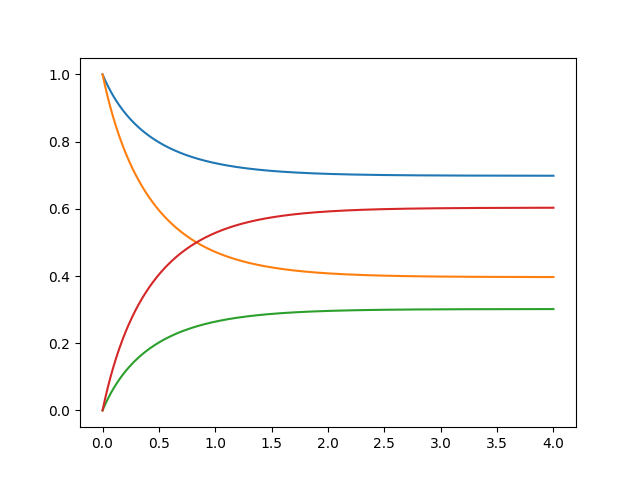

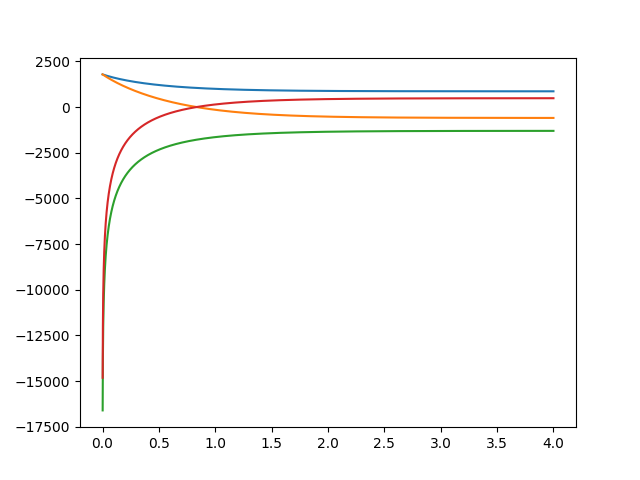

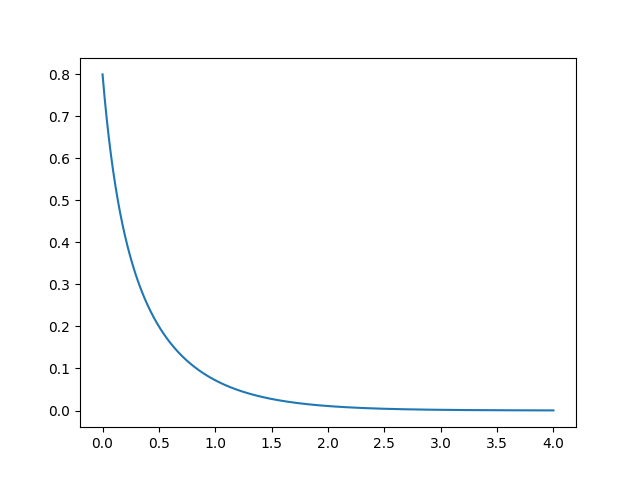

In [16]:
task = run_cellml(cellml, 4, 0.001)

state_plot(task, ['q_1', 'q_2', 'q_3', 'q_4'])
algebraic_plot(task, ['u_q_1', 'u_q_2', 'u_q_3', 'u_q_4'])
algebraic_plot(task, ['v_Re_c'])

In [18]:
example_rdf_path = examples_path / 'example_A3_reduced.ttl'
model = BondgraphModelSource(str(example_rdf_path), debug=True).models[0]
show_bondgraph(model)

Elements:
  #L_e
   CR: Derivative(v_L_e, t) = u_L_e/L_L_e
   EQ: v_L_e = u_R_e/R_R_e
  #L_m
   CR: Derivative(v_L_m, t) = a_L_m
   CR: u_L_m = L_L_m*a_L_m
   EQ: v_L_m = v_R_m
  #R_e
   CR: v_R_e = u_R_e/R_R_e
   EQ: u_R_e = -u_Bl_0 - u_L_e + 50.0*sin(100*pi*t)
  #R_m
   CR: u_R_m = R_R_m*v_R_m
   EQ: u_R_m = -L_L_m*a_L_m + u_Bl_1 - q_C_m/C_q_C_m
  #q_C_m
   CR: Derivative(q_C_m, t) = v_q_C_m
   CR: u_q_C_m = q_C_m/C_q_C_m
   EQ: v_q_C_m = v_R_m
  #u_in_e
   CR: u_in_e = 50.0*sin(100*pi*t)
   EQ: v_u_in_e = -u_R_e/R_R_e
Junctions:
  #GY
    u_Bl_0 = Bl*v_R_m
    u_Bl_1 = Bl*v_R_e


CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'label': 'd…

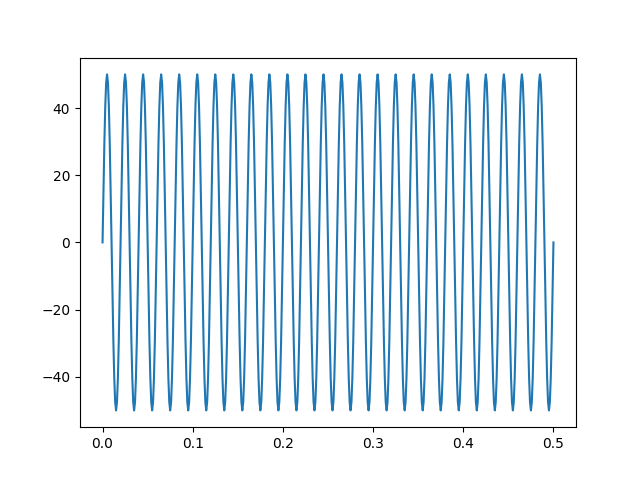

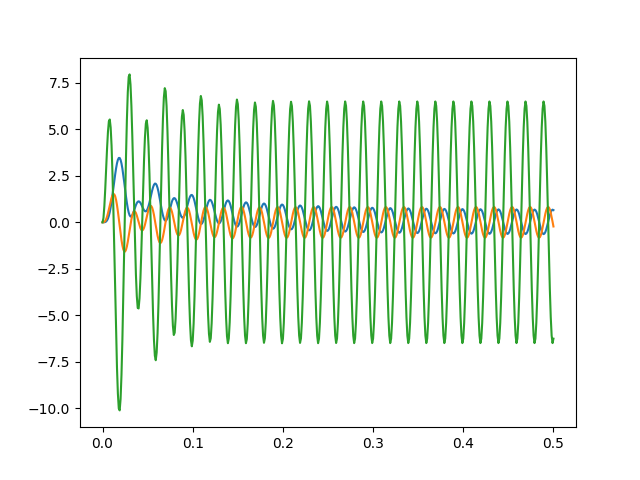

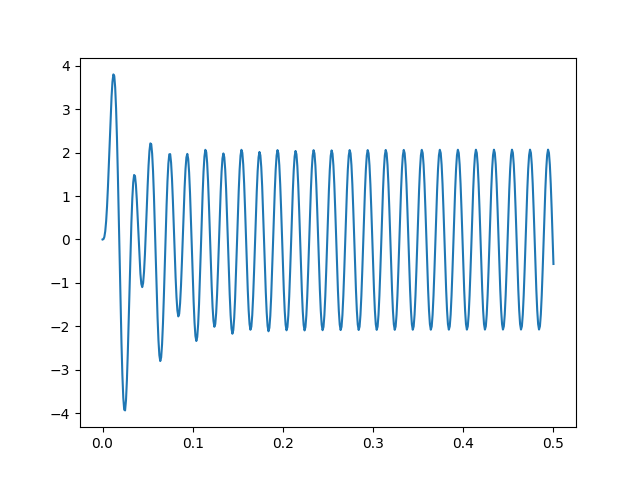

In [19]:
cellml = CellMLModel(model).to_xml()
task = run_cellml(cellml, 0.5, 0.001)

algebraic_plot(task, ['u_in_e'])
algebraic_plot(task, ['u_q_C_m', 'u_R_m', 'u_L_m'])
algebraic_plot(task, ['v_q_C_m'])